In [3]:
import pandas as pd
import numpy as np
import dask.array as da
import dask.dataframe as dd
import time
import math
#import graphviz
from netCDF4 import Dataset
import os,datetime,sys,fnmatch
import h5py




In [4]:
def read_filelist(loc_dir,prefix,unie,fileformat):
    # Read the filelist in the specific directory
    str = os.popen("ls "+ loc_dir + prefix + unie + "*."+fileformat).read()
    fname = np.array(str.split("\n"))
    fname = np.delete(fname,len(fname)-1)
    
    return fname

def read_MODIS(fname1,fname2,verbose=False): # READ THE HDF FILE
    # Read the cloud mask from MYD06_L2 product')
    ncfile=Dataset(fname1,'r')
    CM1km = np.array(ncfile.variables['Cloud_Mask_1km'])
    CM   = (np.array(CM1km[:,:,0],dtype='byte') & 0b00000110) >>1
    #ncfile = Dataset(fname1, "r")
    #CM = myd06.variables["Cloud_Mask_1km"][:,:,:] # Reading Specific Variable 'Cloud_Mask_1km'.
    #CM   = (np.array(CM[:,:,0],dtype='byte') & 0b00000110) >>1
    ncfile.close()
    
    ncfile=Dataset(fname2,'r')
    lat  = np.array(ncfile.variables['Latitude'])
    lon  = np.array(ncfile.variables['Longitude'])
    #ncfile = Dataset(MOD03_files, "r")
    #latitude = myd03.variables["Latitude"][:,:] # Reading Specific Variable 'Latitude'.
    #latitude = np.array(latitude).byteswap().newbyteorder() # Addressing Byteswap For Big Endian Error.
    #longitude = myd03.variables["Longitude"][:,:] # Reading Specific Variable 'Longitude'.
    attr_lat = ncfile.variables['Latitude']._FillValue
    attr_lon = ncfile.variables['Longitude']._FillValue
    """#Use _FillValue to remove fill data in lat & lon
    lat[np.where(lat == attr_lat)] = 0.0
    lon[np.where(lat == attr_lat)] = 0.0
    CM [np.where(lat == attr_lat)] = 0.5 #which will not be identified by lines 80-83 
    lat[np.where(lon == attr_lon)] = 0.0
    lon[np.where(lon == attr_lon)] = 0.0
    CM [np.where(lon == attr_lon)] = 0.5 #which will not be identified by lines 80-83
    ncfile.close()"""
    return lat,lon,CM




In [5]:
def value_locate(refx, x):
    refx = np.array(refx)
    x = np.array(x)
    loc = np.zeros(len(x), dtype='int')
    
    for i in np.arange(len(x)):
        ix = x[i]
        ind = ((refx - ix) <= 0).nonzero()[0]
        if len(ind) == 0:
            loc[i] = -1
        else: loc[i] = ind[-1]

    return loc

def division(n, d):

    div = np.zeros(len(d))
    for i in range(len(d)):
        if d[i] >0:
          div[i]=n[i]/d[i]
        else: div[i]=None 

    return div

def countzero(x, axis=1):
    #print(x)
    count0 = 0
    count1 = 0
    for i in x:
        if i <= 1:
            count0 +=1
    #print(count0/len(x))
    return (count0,len(x))

satellite = 'Aqua'

yr = [2008]
mn = [1] #np.arange(1,13)  #[1]
dy = [1] #np.arange(1,32) # [1] #np.arange(1,31)
lat_bnd = np.arange(-90,91,1)# latitude and longtitude boundaries of level-3 grid
lon_bnd = np.arange(-180,180,1)
nlat = 180
nlon = 360

TOT_pix      = np.zeros(nlat*nlon)
CLD_pix      = np.zeros(nlat*nlon)




In [6]:
MYD06_dir= '/Users/dprakas1/Desktop/modis_files/'
MYD06_prefix = 'MYD06_L2.A2008'
MYD03_dir= '/Users/dprakas1/Desktop/modis_files/'
MYD03_prefix = 'MYD03.A2008'
fileformat = 'hdf'

fname1,fname2 = [],[]


days = np.arange(1,31,dtype=np.int)
for day in days:
    dc ='%03i' % day
    fname_tmp1 = read_filelist(MYD06_dir,MYD06_prefix,dc,fileformat)
    fname_tmp2 = read_filelist(MYD03_dir,MYD03_prefix,dc,fileformat)
    fname1 = np.append(fname1,fname_tmp1)
    fname2 = np.append(fname2,fname_tmp2)

# Initiate the number of day and total cloud fraction
files  = np.arange(len(fname1))



for j in range(0,1):#hdfs:
    print('steps: ',j+1,'/ ',(fname1)) 

    # Read Level-2 MODIS data
    lat,lon,CM = read_MODIS(fname1[j],fname2[j])
print((fname2))
#rint(CM)
#lat = lat.ravel()
#lon = lon.ravel()
#CM  = CM.ravel()
CM.shape    




steps:  1 /  ['/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0000.006.2013341193524.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0005.006.2013341193207.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0010.006.2013341192125.hdf']
['/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0000.006.2012066122450.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0005.006.2012066122516.hdf'
 '/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0010.006.2012066122416.hdf']


(2030, 1354)

In [7]:
combs=[]
for x in range(-89,91):
    for y in range(-179,181):
        combs.append((x, y))
df_1=pd.DataFrame(combs)
df_1.columns=['Latitude','Longitude']

In [8]:
df_1.head()

,Latitude,Longitude
0,-89,-179
1,-89,-178
2,-89,-177
3,-89,-176
4,-89,-175


In [90]:
b1=[]
cloud_pix = np.zeros((180, 360))
for x,y in zip(fname1,fname2):
    cm = np.zeros((2030,1354), dtype=np.float32)
    lat = np.zeros((2030,1354), dtype=np.float32)
    lon = np.zeros((2030,1354), dtype=np.float32)
    print(x,y)
    myd06 = Dataset(x, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    print("CM intial shape:",CM.shape)
    cm = np.concatenate((cm,CM))
    print("CM shape after con:",CM.shape)
    cm=np.ravel(cm)
    print("cm shape after ravel:",cm.shape)
    myd03 = Dataset(y, "r")
    latitude = myd03.variables["Latitude"][:,:]
    longitude = myd03.variables["Longitude"][:,:]
    print("Lat intial shape:",latitude.shape)
    print("lon intial shape:",longitude.shape)
    
    
    lat = np.concatenate((lat,latitude))
    lon = np.concatenate((lon,longitude))
    print("lat shape after con:",lat.shape)
    print("lon shape after con:",lon.shape)
    
    lat=np.ravel(latitude)
    lon=np.ravel(longitude)
    
    print("lat shape after ravel:",lat.shape)
    print("lon shape after ravel:",lon.shape)
    cm=cm.astype(int)
    lon=lon.astype(int)
    lat=lat.astype(int)
    #print(lat,lon)
    d = {'Latitude' :  pd.Series(lat), 'Longitude' : pd.Series(lon),'CM':pd.Series(cm)} #Reading the values in a pandas dataframe
    df = pd.DataFrame(d,columns=['Latitude', 'Longitude','CM'])
    #print(df.head())
    df2=df.groupby(['Longitude','Latitude']).CM.apply(countzero)
    df3=df2.reset_index()
    #df3[['CLD_pix','TOT_pix']]=pd.DataFrame(df3['CM'].tolist(),index=df3.index)
    #print(df3.head())
    #CF=pd.DataFrame(df3['CLD_pix']/df3['TOT_pix'])
    #print(CF)
    
    df4=pd.merge(df_1, df3,on=('Longitude','Latitude'), how='left')
    
    #df5=df4.fillna(0)
    #print(df5.head())
    
    b1.append(df4['CM'])
    
    

/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0000.006.2013341193524.hdf /Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0000.006.2012066122450.hdf
CM intial shape: (2030, 1354)
CM shape after con: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (2748620,)
lon shape after ravel: (2748620,)
/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0005.006.2013341193207.hdf /Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0005.006.2012066122516.hdf
CM intial shape: (2030, 1354)
CM shape after con: (2030, 1354)
cm shape after ravel: (5497240,)
Lat intial shape: (2030, 1354)
lon intial shape: (2030, 1354)
lat shape after con: (4060, 1354)
lon shape after con: (4060, 1354)
lat shape after ravel: (2748620,)
lon shape after ravel: (2748620,)
/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0010.006.2013341192125.hdf /Users/dpraka

In [91]:
x=pd.concat(b1,axis=1)
y=x.sum(axis=1)
y_ax=y.values

In [92]:
type(y_ax)
y_re=y_ax.reshape(180,360)
y_re

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:

for MOD06_file,MOD03_file in zip(fname1,fname2):
    print(MOD06_file)
    print(MOD03_file)
    cm = np.zeros((2030,1354), dtype=np.float32)
    lat = np.zeros((2030,1354), dtype=np.float32)
    lon = np.zeros((2030,1354), dtype=np.float32)
    myd06 = Dataset(MOD06_file, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    #cm = da.from_array(CM, chunks =(2030,1354))
    print(("CM shape is:",CM.shape))
    cm = np.concatenate((cm,CM))
    print(("cm shape is after con:",cm.shape))
    cm=np.ravel(CM)
    cm=cm.astype(int)
   
    myd03 = Dataset(MOD03_file, "r")
    latitude = myd03.variables["Latitude"][:,:]
    longitude = myd03.variables["Longitude"][:,:]
    print((latitude.shape))
    print((longitude.shape))
    lat = np.concatenate((lat,latitude))
    lon = np.concatenate((lon,longitude))
    print((lat.shape))
    print((lon.shape))
    lat=np.ravel(lat)
    lon=np.ravel(lon)
    lon=lon.astype(int)
    lat=lat.astype(int)
    #print(np.unique(cm))
    #print(np.unique(lat))
    #print(np.unique(lon))
    d = {'Latitude' :  pd.Series(lat), 'Longitude' : pd.Series(lon),'CM':pd.Series(cm)} #Reading the values in a pandas dataframe
    df = pd.DataFrame(d,columns=['Latitude', 'Longitude','CM']) #Creating a pandas dataframe
    df2=df.groupby(['Longitude','Latitude']).CM.apply(countzero)
    df3=df2.reset_index()
    #print(df3.head())


/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0000.006.2013341193524.hdf
/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0000.006.2012066122450.hdf
('CM shape is:', (2030, 1354))
('cm shape is after con:', (4060, 1354))
(2030, 1354)
(2030, 1354)
(4060, 1354)
(4060, 1354)
/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0005.006.2013341193207.hdf
/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0005.006.2012066122516.hdf
('CM shape is:', (2030, 1354))
('cm shape is after con:', (4060, 1354))
(2030, 1354)
(2030, 1354)
(4060, 1354)
(4060, 1354)
/Users/dprakas1/Desktop/modis_files/MYD06_L2.A2008001.0010.006.2013341192125.hdf
/Users/dprakas1/Desktop/modis_files/MYD03.A2008001.0010.006.2012066122416.hdf
('CM shape is:', (2030, 1354))
('cm shape is after con:', (4060, 1354))
(2030, 1354)
(2030, 1354)
(4060, 1354)
(4060, 1354)


In [94]:
mod06_file=[]
for i in (fname1):
    print(mod06_file.append(i))
    myd06 = Dataset(MOD06_file, "r")
    CM = myd06.variables["Cloud_Mask_1km"][:,:,0]# Reading Specific Variable 'Cloud_Mask_1km'.
    CM = (np.array(CM,dtype='byte') & 0b00000110) >>1
    CM = np.array(CM).byteswap().newbyteorder()
    #cm = da.from_array(CM, chunks =(2030,1354))
    print(type(cm))
    cm=np.ravel(cm)
    cm=cm.astype(int)
    print(np.unique(cm))

None
<class 'numpy.ndarray'>
[0]
None
<class 'numpy.ndarray'>
[0]
None
<class 'numpy.ndarray'>
[0]


In [6]:
lat = np.zeros((2030,1354), dtype=np.float32)
lon = np.zeros((2030,1354), dtype=np.float32)
for MOD03_file in fname2:
    #print(MOD03_file)
    myd03 = Dataset(MOD03_file, "r")
    latitude = myd03.variables["Latitude"][:,:] # Reading Specific Variable 'Latitude'.
    lat = np.concatenate((lat,latitude))


    longitude = myd03.variables["Longitude"][:,:] # Reading Specific Variable 'Longitude'.
    lon = np.concatenate((lon,longitude))
    
print('Longitude Shape Is: ',lon.shape)
print('Latitude Shape Is: ',lat.shape)




Longitude Shape Is:  (8120, 1354)
Latitude Shape Is:  (8120, 1354)


In [7]:
cm=np.ravel(cm)
lat=np.ravel(lat)
lon=np.ravel(lon)



In [8]:
lon=lon.astype(int)
lat=lat.astype(int)
cm=cm.astype(int)

In [9]:
d = {'Latitude' :  pd.Series(lat), 'Longitude' : pd.Series(lon),'CM':pd.Series(cm)} #Reading the values in a pandas dataframe
df = pd.DataFrame(d,columns=['Latitude', 'Longitude','CM']) #Creating a pandas dataframe


In [10]:
df.shape

(10994480, 3)

In [11]:
df1=dd.from_pandas(df,npartitions=1)

In [22]:
df1

,Latitude,Longitude,CM
npartitions=1,,,
0,int64,int64,int64
10994479,...,...,...


In [12]:
df2=df1.groupby(['Longitude','Latitude']).CM.apply(countzero)
type(df2)

/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


dask.dataframe.core.Series

In [13]:
#df3=df2.reset_index()
#df3.compute()
df3=df2.to_frame()


In [14]:
import pandas as pd
combs=[]
for x in range(-89,91):
    for y in range(-179,181):
        combs.append((x, y))

In [15]:
df_1=pd.DataFrame(combs)
df_1.columns=['Latitude','Longitude']
df_2=dd.from_pandas(df_1,npartitions=1)


In [25]:
#how='left', left_on=leftcolumns
df4=df_2.merge(df3, how='left',on=('Latitude','Longitude'))
#df4=dd.merge(df_2,df3,left_on='Longitude',right_on='Latitude', how='left')
df4

,Latitude,Longitude,CM
npartitions=1,,,
,int64,int64,float64
,...,...,...


In [26]:
df4.compute()

,Latitude,Longitude,CM
0,-89,-179,NaN
1,-89,-178,NaN
2,-89,-177,NaN
3,-89,-176,NaN
4,-89,-175,NaN
5,-89,-174,NaN
6,-89,-173,NaN
7,-89,-172,NaN
8,-89,-171,NaN
9,-89,-170,NaN


In [29]:
df5=df4['CM'].values

In [30]:
type(df5)

dask.array.core.Array

In [31]:
df5

dask.array<values, shape=(nan,), dtype=float64, chunksize=(nan,)>

In [23]:
#b=df5.reshape(180,360)
b=df4['CM'].to_dask_array(lengths=True).reshape([180,360])

In [24]:
b

dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360)>

In [93]:
total_cloud_fraction = y_re
out_name = '/Users/dprakas1/Desktop/y_resh.hdf5'
def save_hdf(out_name,total_cloud_fraction,lat_bnd,lon_bnd):
    f=h5py.File(out_name,'w')
    PCentry=f.create_dataset('CF',data=total_cloud_fraction)
    PCentry.dims[0].label='lat_bnd'
    #PCentry.dims[1].label='lon_bnd'

    PC=f.create_dataset('lat_bnd',data=lat_bnd)
    PC.attrs['units']='degrees'
    PC.attrs['long_name']='Latitude_boundaries'

    PC=f.create_dataset('lon_bnd',data=lon_bnd)
    PC.attrs['units']='degrees'
    PC.attrs['long_name']='Longitude_boundaries'
    f.close()
    print(out_name+' Saved!!')

save_hdf(out_name,total_cloud_fraction,lat_bnd,lon_bnd)




/Users/dprakas1/Desktop/y_resh.hdf5 Saved!!


/Users/dprakas1/Documents/comparisons.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/Users/dprakas1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


Maximum absolute bias:0.0000
Minimum absolute bias:0.0000


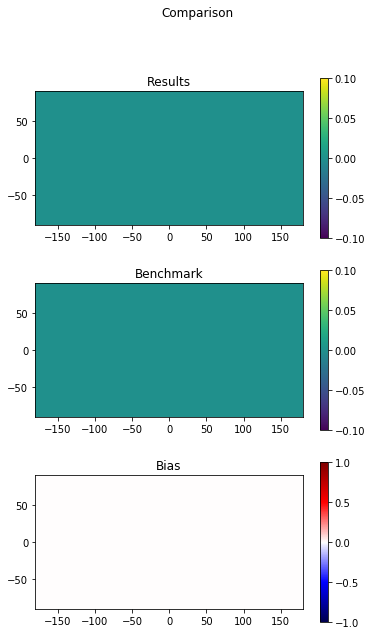

In [94]:
#for one day's data
import h5py
import numpy as np
from comparisons import readData, doPlot
#benchmark_p="/Users/dprakas1/Documents/"
#CF_BMK,_,_=readData(benchmark_p+"MODAgg_3var_parMonth_20080101.hdf5")#Benchmark

f=h5py.File('/Users/dprakas1/Desktop/y_resh.hdf5','r')
CF_res=f['CF'][:]
fig1,fig2=doPlot(CF_res,CF_res,'Comparison')

fig1.show()


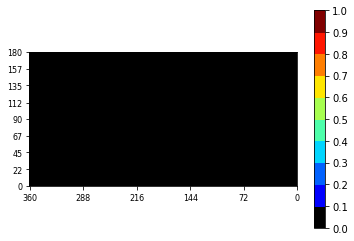

In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import calendar
import pprint
data = y_re

data_shape = data.shape

cmap = [(0.0,0.0,0.0)] + [(cm.jet(i)) for i in range(1,256)] 
cmap = mpl.colors.ListedColormap(cmap)

bounds = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = plt.imshow(np.fliplr(data), cmap=cmap, norm=norm,
                  interpolation='none', origin='lower')

cbar_bounds = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cbar_ticks = [0.0, 0.1, 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]             
               
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks, fontsize=10)

l = [int(i) for i in np.linspace(0,data_shape[1],6)]
plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=8 )

l = [int(i) for i in np.linspace(0,data_shape[0],9)]
plt.yticks(l, l, rotation=0, fontsize=8 )

title = 'Cloud Fraction \n MYD06 C6 ({}-{:02d}-{:02d}; {:02d}h{:02d})'
#plt.title(title.format( year, month, day, hh, mm), fontsize=10)
plt.show()